# Pairwise distances with ONNX (pdist)

Function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) computes pairwise distances between observations in n-dimensional space. It is not that difficult to convert that into *ONNX* when the dimension of the input is always the same. What if not?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Function pdist

The function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) distances. Let's denote a list of vectors $(X_1, ..., X_n)$, function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) returns the matrix $D=(d_{ij})$ where $d_{ij}=dist(X_i, X_j)=\lVert X_i - X_j \rVert^2$.

In [3]:
import numpy
from scipy.spatial.distance import pdist, squareform

M = numpy.array([[0, 1],
                 [1, 2],
                 [0.1, 1.1],
                 [2, 2]], dtype=float)

d1 = squareform(pdist(M, metric='sqeuclidean'))
d1

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

The two following functions are implemented to reduce the number of allocations the algorithm requires.

In [4]:
def custom_pdist(M):
    n = M.shape[0]
    res = numpy.zeros((n, n))
    buffer = numpy.empty(M.shape)
    for i in range(n):
        numpy.subtract(M, M[i], out=buffer)  # broadcasted substraction
        numpy.square(buffer, out=buffer)
        res[i, :] = numpy.sum(buffer, axis=1)
    return res

d2 = custom_pdist(M)
d2

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

This function computes $n^2$ distances wheres only $\frac{n(n-1)}{2}$ are necessary since the final matrix is symmetric. Let's change the implementation to reflect that.

In [5]:
def custom_pdist_lower(M):
    n = M.shape[0]
    res = numpy.zeros((n, n))
    buffer = numpy.empty((M.shape[0]-1, M.shape[1]))
    a = numpy.empty(M.shape[0])
    for i in range(1, n):
        numpy.subtract(M[:i], M[i], out=buffer[:i])  # broadcasted substraction
        numpy.square(buffer[:i], out=buffer[:i])
        numpy.sum(buffer[:i], axis=1, out=a[:i])
        res[:i, i] = a[:i]
        res[i, :i] = a[:i]
    return res

d3 = custom_pdist_lower(M)
d3

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

## Loop mechanism in ONNX

Operator [Loop](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Loop) seems appropriate but it is just a loop wheras [Scan](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Scan) holds accumulator. The first graph is what is repeated inside the loop.

In [6]:
from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxIdentity, OnnxScan
from skl2onnx.common.data_types import FloatTensorType

initial = numpy.array([0, 0]).astype(numpy.float32).reshape((2,))
x = numpy.array([1, 2, 3, 4, 5, 6]).astype(numpy.float32).reshape((3, 2))

add_node = OnnxAdd('sum_in', 'next', output_names=['sum_out'], op_version=12)
id_node = OnnxIdentity(add_node, output_names=['scan_out'], op_version=12)

scan_body = id_node.to_onnx(
    {'sum_in': initial, 'next': initial},
    outputs=[('sum_out', FloatTensorType()),
             ('scan_out', FloatTensorType())])

# add -l 1 if nothing shows up
%onnxview scan_body

The operator [Scan](https://github.com/onnx/onnx/blob/master/docs/Operators.md#Scan) repeats this graph a couple of times. *sum_in* is an accumulator, *next* is the iterated row from the input matrix.

In [7]:
node = OnnxScan('initial', 'x', output_names=['y', 'z'],
                num_scan_inputs=1, body=scan_body.graph)

model_def = node.to_onnx(
    {'initial': initial, 'x': x},
    outputs=[('y', FloatTensorType()),
             ('z', FloatTensorType())])

# add -l 1 if nothing shows up
%onnxview model_def

All together in the same graph.

In [8]:
# add -l 1 if nothing shows up
%onnxview model_def -r 1

In [9]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(model_def)
res = oinf.run({'initial': initial, 'x': x})
res['y']

array([ 9., 12.], dtype=float32)

In [10]:
res['z']

array([[ 1.,  2.],
       [ 4.,  6.],
       [ 9., 12.]], dtype=float32)

## Back to pdist

[sklearn-onnx](https://github.com/onnx/sklearn-onnx) implements function *pdist* with *ONNX* operators. The parameter ``inputs=[('x', FloatTensorType())`` tels the method ``to_onnx`` that the dimension of the inputs is not fixed and should not be checked.

In [11]:
# from skl2onnx.algebra.complex_functions import squareform_pdist_

from collections import OrderedDict
from skl2onnx.algebra.onnx_ops import (
    OnnxSub, OnnxReduceSumSquare, OnnxSqueeze,
    OnnxIdentity, OnnxScan)
from skl2onnx.common.data_types import FloatTensorType
from mlprodict.tools import get_opset_number_from_onnx


def squareform_pdist(X, **kwargs):
    """Returns the ONNX graph which computes
    ``squareform(pdist(X, metric='sqeuclidean')``."""

    # The subgraph executed at every iteration.
    opv = get_opset_number_from_onnx()
    diff = OnnxSub('next_in', 'next', output_names=['diff'], op_version=opv)
    id_next = OnnxIdentity('next_in', output_names=['next_out'], op_version=opv)
    norm = OnnxReduceSumSquare(diff, output_names=['norm'], axes=[1], op_version=opv)
    flat = OnnxSqueeze(norm, output_names=['scan_out'], axes=[1], op_version=opv)
    scan_body = id_next.to_onnx(
        OrderedDict([('next_in', FloatTensorType()),
                     ('next', FloatTensorType())]),
        # Size must be empty otherwise onnxruntime fails
        # at execution time if it receives different a matrix
        # with different shape. With 'None', the same ONNX graph
        # can compute pairwise distance for any shape.
        outputs=[('next_out', FloatTensorType([None, None])),
                 ('scan_out', FloatTensorType([None]))],
        other_outputs=[flat])

    # The loop.
    # 'scan0_{idself}' means the variable name will include
    # id(OnnxScan), this is needed if squareform_pdist is used
    # twice in the same graph.
    node = OnnxScan(X, X, output_names=['scan0_{idself}', 'scan1_{idself}'],
                    num_scan_inputs=1, body=scan_body.graph, op_version=opv,
                    **kwargs)
    return node[1]    

opv = get_opset_number_from_onnx()
onnx_fct = OnnxIdentity(squareform_pdist('x'), output_names='Y', op_version=opv)
model_def = onnx_fct.to_onnx(inputs=[('x', FloatTensorType())])

# add -l 1 if nothing shows up
%onnxview model_def

Notice the double arrow. Input _x_ is used twice, once as an permanent state involved in broacasted substract, another time to iterator rows. On the other side, the first output of operator *Scan* is a permanent state equal to the input, the second one is an aggregation of results produced at each iteration. Each of those produces a row of a final matrix.

In [12]:
oinf = OnnxInference(model_def)
body = oinf['Sc_Scan', 'body']

# add -l 1 if nothing shows up
%onnxview body.g

All together.

In [13]:
# add -l 1 if nothing shows up
%onnxview model_def -r 1

Let's now execute the graph and compare it with the original graph.

In [14]:
d1 = squareform(pdist(M, metric='sqeuclidean'))
d1

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

In [15]:
oinf.run({'x': M})['Y']

array([[0.  , 2.  , 0.02, 5.  ],
       [2.  , 0.  , 1.62, 1.  ],
       [0.02, 1.62, 0.  , 4.42],
       [5.  , 1.  , 4.42, 0.  ]])

In [16]:
%timeit squareform(pdist(M, metric='sqeuclidean'))

30.5 µs ± 5.66 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit custom_pdist(M)

44.4 µs ± 943 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit custom_pdist_lower(M)

41.9 µs ± 708 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%timeit oinf.run({'x': M})['Y']

180 µs ± 7.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
M32 = M.astype(numpy.float32)

In [21]:
from mlprodict.tools import get_ir_version_from_onnx
model_def.ir_version = get_ir_version_from_onnx()

In [22]:
oinfrt = OnnxInference(model_def, runtime="onnxruntime1")
oinfrt.run({'x': M32})['Y']

array([[0.        , 2.        , 0.02000001, 5.        ],
       [2.        , 0.        , 1.6199999 , 1.        ],
       [0.02000001, 1.6199999 , 0.        , 4.42      ],
       [5.        , 1.        , 4.42      , 0.        ]], dtype=float32)

In [23]:
%timeit oinfrt.run({'x': M32})['Y']

52.1 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Benchmark

In [24]:
from timeit import Timer


def measure_time(name, stmt, context, repeat=10, number=10):
    tim = Timer(stmt, globals=context)
    res = numpy.array(tim.repeat(repeat=repeat, number=number))
    res /= number
    mean = numpy.mean(res)
    dev = numpy.mean(res ** 2)
    dev = (dev - mean**2) ** 0.5
    return dict(average=mean, deviation=dev, min_exec=numpy.min(res),
                max_exec=numpy.max(res), repeat=repeat, number=number,
                nrows=context['M'].shape[0], ncols=context['M'].shape[1],
                name=name)

measure_time("scipy", "squareform(pdist(M, metric='sqeuclidean'))",
             context={'squareform': squareform, 'M': M,
                      'pdist': pdist})

{'average': 5.8884999999690985e-05,
 'deviation': 3.6757618254979443e-06,
 'min_exec': 5.3900000000339785e-05,
 'max_exec': 6.38600000002043e-05,
 'repeat': 10,
 'number': 10,
 'nrows': 4,
 'ncols': 2,
 'name': 'scipy'}

In [25]:
from tqdm import trange

def generator():
    for feat in [5, 10, 50, 100]:
        for n in [5, 10, 20, 50, 100, 400, 1000]:
            if n <= 500 or feat <= 10:
                yield feat, n
            
all_values = list(generator())

rows = []

with trange(len(all_values)) as t:
    for i in t:        
        feat, n = all_values[i]
        t.set_description("feat=%d n=%d" % (feat, n))
        M = numpy.random.rand(n, feat)

        context = {'squareform': squareform, 'M': M, 'pdist': pdist}
        res = measure_time("scipy", "squareform(pdist(M, metric='sqeuclidean'))", context=context)
        res['dimres'] = squareform(pdist(M, metric='sqeuclidean')).shape[0]
        rows.append(res)

        context = {'M': M, 'custom_pdist': custom_pdist}
        res = measure_time("numpy", "custom_pdist(M)", context=context)
        res['dimres'] = custom_pdist(M).shape[0]
        rows.append(res)

        context = {'M': M, 'custom_pdist_lower': custom_pdist_lower}
        res = measure_time("numpy-lower", "custom_pdist_lower(M)", context=context)
        res['dimres'] = custom_pdist_lower(M).shape[0]
        rows.append(res)

        context = {'oinf': oinf, 'M': M}
        res = measure_time("onnx-py", "oinf.run({'x': M})['Y']", context=context)
        res['dimres'] = oinf.run({'x': M})['Y'].shape[0]
        rows.append(res)

        M32 = M.astype(numpy.float32)
        context = {'oinfrt': oinfrt, 'M': M32}
        res = measure_time("onnx-rt", "oinfrt.run({'x': M})['Y']", context=context)
        res['dimres'] = oinfrt.run({'x': M32})['Y'].shape[0]
        rows.append(res)

    
from pandas import DataFrame
df = DataFrame(rows)
df.head()

feat=100 n=400: 100%|██████████| 26/26 [01:25<00:00,  3.28s/it]


,average,deviation,min_exec,max_exec,repeat,number,nrows,ncols,name,dimres
0,0.000038,0.000015,0.000027,0.000066,10,10,5,5,scipy,5
1,0.000074,0.000013,0.000069,0.000114,10,10,5,5,numpy,5
2,0.000079,0.000018,0.000066,0.000126,10,10,5,5,numpy-lower,5
3,0.000687,0.000685,0.000219,0.002040,10,10,5,5,onnx-py,5
4,0.000107,0.000027,0.000061,0.000140,10,10,5,5,onnx-rt,5


In [26]:
from pandas import pivot_table
piv = pivot_table(df, index=["nrows"], columns= ['ncols', 'name'], values='average')
piv.head().T

nrows                   5         10        20        50        100
ncols name                                                         
5     numpy        0.000074  0.000153  0.000313  0.000599  0.001339
      numpy-lower  0.000079  0.000174  0.000318  0.000677  0.001480
      onnx-py      0.000687  0.000503  0.000966  0.002131  0.004150
      onnx-rt      0.000107  0.000100  0.000184  0.000518  0.000974
      scipy        0.000038  0.000037  0.000051  0.000074  0.000073
10    numpy        0.000117  0.000173  0.000282  0.000682  0.001539
      numpy-lower  0.000075  0.000154  0.000294  0.000699  0.001639
      onnx-py      0.000230  0.000466  0.000806  0.002139  0.004742
      onnx-rt      0.000063  0.000096  0.000181  0.000467  0.001090
      scipy        0.000050  0.000040  0.000062  0.000069  0.000124
50    numpy        0.000135  0.000118  0.000305  0.000866  0.002249
      numpy-lower  0.000060  0.000138  0.000289  0.000923  0.002068
      onnx-py      0.000269  0.000431  0.000842  0.002424  0.005815
      onnx-rt      0.000065  0.000103  0.000194  0.000520  0.001344
      scipy        0.000043  0.000039  0.000069  0.000123  0.000300
100   numpy        0.000139  0.000152  0.000336  0.001050  0.002767
      numpy-lower  0.000117  0.000139  0.000337  0.000914  0.002395
      onnx-py      0.000344  0.000437  0.000904  0.002728  0.006586
      onnx-rt      0.000068  0.000108  0.000199  0.000605  0.001641
      scipy        0.000087  0.000036  0.000086  0.000187  0.000588

In [27]:
%matplotlib inline

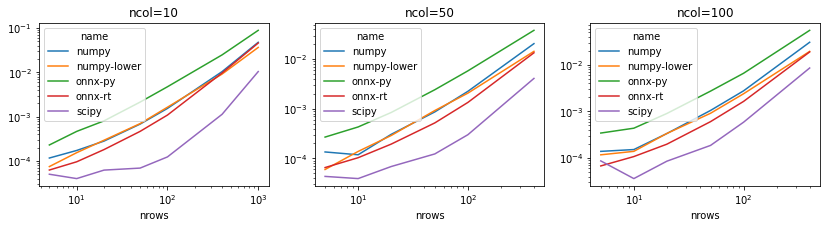

In [28]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
for i, ncol in enumerate([10, 50, 100]):
    piv = df[df.ncols==ncol].pivot("nrows", "name", "average")
    piv.plot(ax=ax[i], logy=True, logx=True)
    ax[i].set_title("ncol=%d" % ncol)
ax;

Curves are not linear and rather difficult to interpret. The algorithm *numpy-lower* and *scipy* should be close as the cost of both algorithm are similar. However, *scipy* reduces the number of trips between C and python. The C implementation of the distance is here:
[sqeuclidean_distance_double](https://github.com/scipy/scipy/blob/master/scipy/spatial/src/distance_impl.h#L50). The final cost is a combination of computation, multithreading, allocations...

In [29]:
from pyquickhelper.pycode.profiling import profile
M = numpy.random.rand(100, 10)

pr1, df1 = profile(lambda: [squareform(pdist(M, metric='sqeuclidean')) for i in range(0, 1000)],
                   as_df=True)
pr2, df2 = profile(lambda: [custom_pdist_lower(M) for i in range(0, 1000)], as_df=True)

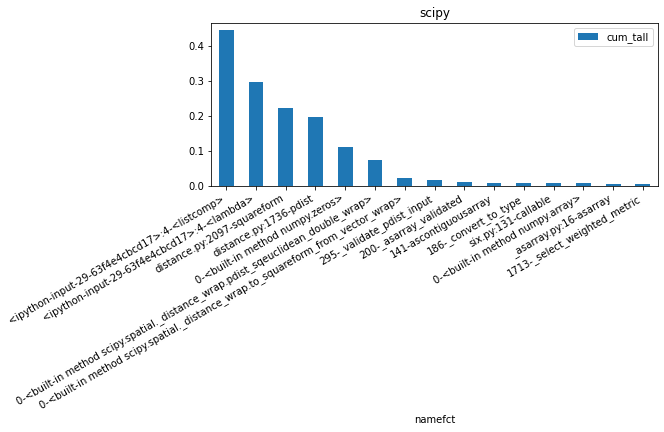

In [30]:
ax = df1[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(
    kind='bar', figsize=(8, 3), rot=30)
ax.set_title("scipy")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right')

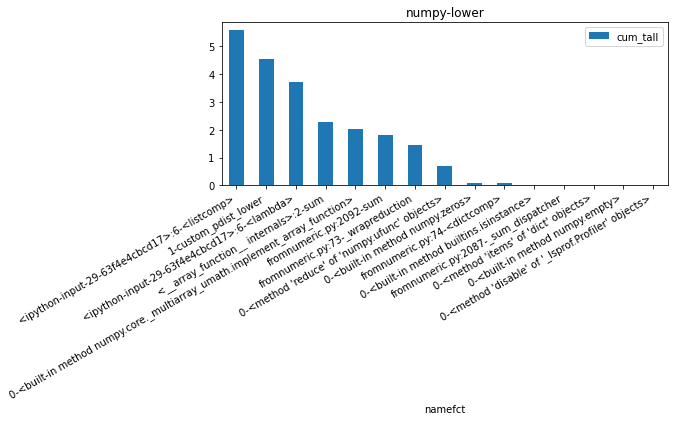

In [31]:
ax = df2[['namefct', 'cum_tall']].head(n=15).set_index('namefct').plot(
    kind='bar', figsize=(8, 3), rot=30)
ax.set_title("numpy-lower")
for la in ax.get_xticklabels():
    la.set_horizontalalignment('right');    

[Universal function](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) do not seem to be very efficient in our case. The last graph shows time ratio between implementations of *pdist* and the baseline *scipy*.

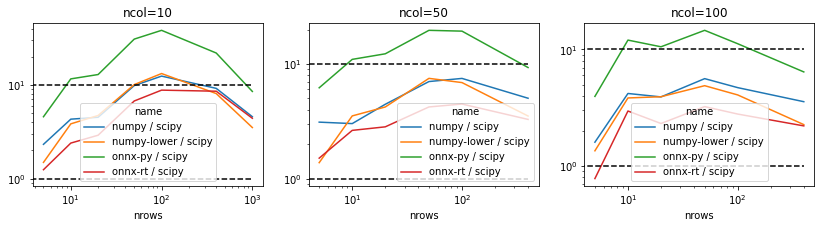

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))
for i, ncol in enumerate([10, 50, 100]):
    piv = df[df.ncols==ncol].pivot("nrows", "name", "average")
    piv['numpy / scipy'] = piv['numpy'] / piv['scipy']
    piv['numpy-lower / scipy'] = piv['numpy-lower'] / piv['scipy']
    piv['onnx-py / scipy'] = piv['onnx-py'] / piv['scipy']
    piv['onnx-rt / scipy'] = piv['onnx-rt'] / piv['scipy']
    piv = piv[['numpy / scipy', 'numpy-lower / scipy', 
               'onnx-py / scipy', 'onnx-rt / scipy']]
    piv.plot(ax=ax[i], logy=True, logx=True)
    ax[i].plot([0, max(piv.index)], [1, 1], '--', color='black')
    ax[i].plot([0, max(piv.index)], [10, 10], '--', color='black')
    ax[i].set_title("ncol=%d" % ncol)
ax;

## Test with a new operator CDist

The final question is: *should we introduce a new operator into [ONNX specifications](https://github.com/onnx/onnx/blob/master/docs/Operators.md)?* The function [pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) is not necessarily often used for a big number of observations as the square matrix it produces will even bigger. It seems reasonable. We showed that a python runtime based on *numpy* would not help, the implementation must be done in C++ or directly used the *scipy* version. The experiment was done with a [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html). The following section tests with and without a new operator ``CDist`` reusing *scipy* implementation.

In [33]:
import numpy
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared
from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference


iris = load_iris()
X, y = iris.data, iris.target
X_train, X_test, y_train, __ = train_test_split(X, y, random_state=12)
clr = GaussianProcessRegressor(ExpSineSquared(), alpha=20.)
clr.fit(X_train, y_train)

model_def = to_onnx(clr, X_train)

%onnxview model_def -r 1

In [34]:
model_def_cdist = to_onnx(clr, X_train,
                          options={GaussianProcessRegressor: {'optim': 'cdist'}})
%onnxview model_def_cdist

In [35]:
oinf = OnnxInference(model_def)
oinf_cdist = OnnxInference(model_def_cdist)

In [36]:
%timeit oinf.run({'X': X_test})

4.76 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
%timeit oinf_cdist.run({'X': X_test})

390 µs ± 5.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
oinfrt = OnnxInference(model_def, runtime="onnxruntime1")
oinfrt_cdist = OnnxInference(model_def_cdist)

In [39]:
%timeit oinfrt_cdist.run({'X': X_test})

411 µs ± 36.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


It is 10 times faster for this datasets so it is worth it. For bigger datasets, we should expect a lower gain but still significant.